In [1]:
# === S&P 500 주가 조회: 첫 번째 셀(한 번만 실행) ===
import pandas as pd
import yfinance as yf
from time import sleep

# 하드코딩된 수집 범위 (요청대로)
DATE_START = "2024-01-01"
DATE_END   = "2024-06-30"  # 6월은 30일까지

# Yahoo 티커 교정(예: BRK.B -> BRK-B)
_TICKER_FIX = {
    "BRK.B": "BRK-B",
    "BF.B":  "BF-B",
}

_CACHE = {}  # 호출 후 캐시

def _download_one(ticker: str, max_retries: int = 3, pause: float = 0.8) -> pd.DataFrame:
    """
    단일 티커를 yfinance로 다운로드하여
    '날짜(YYYY.M.D)' / '종가(Adj Close 반영)' 두 열의 DataFrame으로 반환
    """
    t = ticker.strip().upper()
    t = _TICKER_FIX.get(t, t)

    last_err = None
    for i in range(max_retries):
        try:
            # auto_adjust=True: 배당/분할 반영된 종가를 'Close' 컬럼로 돌려줌
            df = yf.download(
                t,
                start=DATE_START,
                end=DATE_END,
                interval="1d",
                auto_adjust=True,
                actions=False,
                progress=False,
                threads=False,  # 간헐적 403 완화 목적
            )
            if not df.empty:
                # 날짜/종가 2열로 정리
                out = (
                    df[["Close"]]
                    .rename(columns={"Close": "종가"})
                    .reset_index()
                )
                # 날짜를 '2024.1.3' 형식(월/일 앞 0 제거)으로 표시
                out["날짜"] = out["Date"].map(lambda d: f"{d.year}.{d.month}.{d.day}")
                out = out[["날짜", "종가"]].copy()
                out["종가"] = out["종가"].round(2)
                return out
        except Exception as e:
            last_err = e
        # 재시도 전 대기(점증적)
        sleep(pause * (i + 1))

    raise RuntimeError(f"데이터 수집 실패: {t}  (마지막 오류: {last_err})")


def show(ticker: str) -> pd.DataFrame:
    """
    사용법 예)
      show("AAPL")
      show("MSFT")
      show("BRK.B")  # 자동으로 BRK-B로 교정
    결과)
      '날짜' / '종가' 2열 표(DataFrame)를 그대로 반환 (노트북에서 표로 보임)
    """
    t = ticker.strip().upper()
    t = _TICKER_FIX.get(t, t)
    if t not in _CACHE:
        _CACHE[t] = _download_one(t)
    return _CACHE[t]


In [85]:
show("AAPL")



Price,날짜,종가
Ticker,,AAPL
0,2024.1.2,184.08
1,2024.1.3,182.70
2,2024.1.4,180.38
3,2024.1.5,179.66
4,2024.1.8,184.00
...,...,...
119,2024.6.24,206.94
120,2024.6.25,207.86
121,2024.6.26,212.02


In [22]:
def show_cached():
    inv = {v: k for k, v in _TICKER_FIX.items()}  # BRK-B -> BRK.B 되돌림
    tickers = sorted(inv.get(t, t) for t in _CACHE.keys())
    if not tickers:
        print("캐시에 아직 없습니다. show('AAPL') 등으로 먼저 호출하세요.")
        return
    return pd.DataFrame({"티커": tickers})

# 사용 예
# show("AAPL"); show("BRK.B"); show("MSFT")
# show_cached()


In [23]:
show_cached()

,티커
0,A
1,AAPL
2,ABBV
3,ABNB
4,ABT
...,...
295,T
296,TECH
297,TSLA
298,XOM


In [ ]:
# === 그래프 도구 확장: graph_per ===``
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def graph_per(ticker: str, cumulative: bool = False):
    """
    일별 수익률 그래프.
    - cumulative=False: Daily return (p_t / p_{t-1} - 1)
    - cumulative=True : Cumulative return (∏(1+r_t), base=1.0)
    """
    t_raw = ticker.strip().upper()
    df = show(t_raw)  # 기존 show() 재사용 (캐시 기반)

    if df is None or df.empty:
        raise ValueError(f"No data for {t_raw}. Call show('{t_raw}') first.")

    dates = pd.to_datetime(df["날짜"], format="%Y.%m.%d")
    prices = df["종가"].astype(float).to_numpy()

    # 일별 수익률
    ret = np.empty_like(prices, dtype=float)
    ret[0] = 0.0
    ret[1:] = prices[1:] / prices[:-1] - 1.0

    fig, ax = plt.subplots(figsize=(10, 4), dpi=120)
    if cumulative:
        growth = (1.0 + ret).cumprod()
        ax.plot(dates, growth, label="Cumulative return (base=1.0)")
        ax.set_ylabel("Growth factor")
        ax.set_title(f"{t_raw} Cumulative Return — 2024-01-01 to 2024-06-30")
    else:
        ax.plot(dates, ret, label="Daily return")
        ax.axhline(0.0, linewidth=1, alpha=0.5)
        ax.set_ylabel("Daily Return")
        ax.set_title(f"{t_raw} Daily Return — 2024-01-01 to 2024-06-30")

    ax.set_xlabel("Date")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return ax

# 사용 예:
# graph_per("AAPL")              # 일별 수익률
# graph_per("AAPL", cumulative=True)  # 누적 수익률


<Axes: title={'center': 'AAPL Cumulative Return — 2024-01-01 to 2024-06-30'}, xlabel='Date', ylabel='Growth factor'>

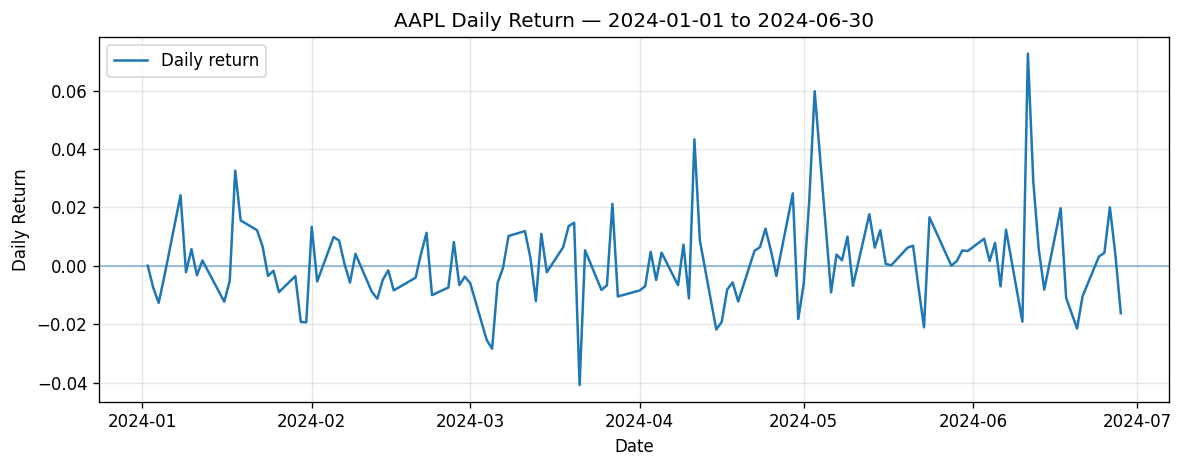

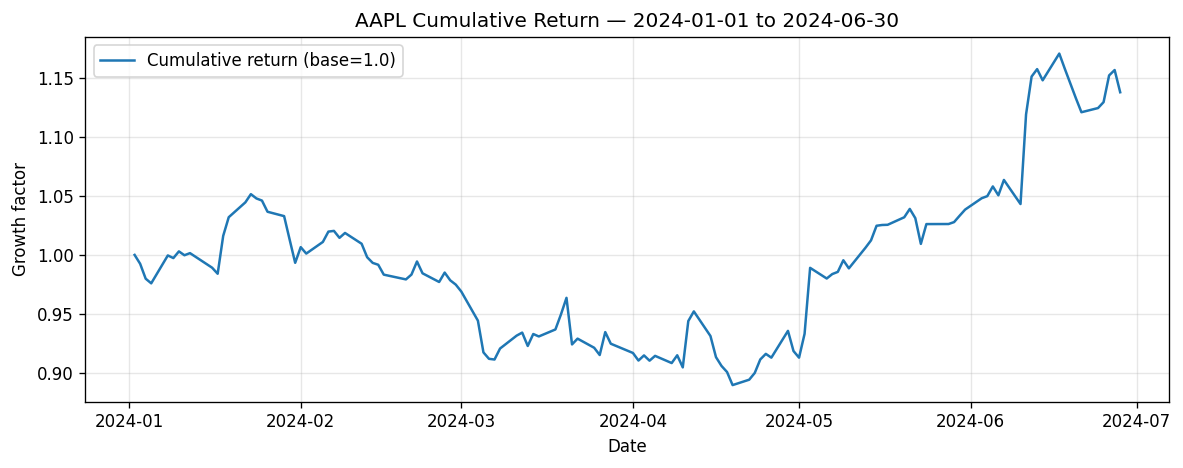

In [29]:
graph_per("AAPL")
graph_per("AAPL", cumulative=True)

In [24]:
# === 그래프 도구 ===
import pandas as pd
import matplotlib.pyplot as plt

def graph(ticker: str, ma=(20, 60), log: bool = False):
    """
    Plot price series from show(ticker) result.
    - ma: (20, 60)처럼 간단 이동평균선 창 길이. 끄려면 ma=() 또는 None
    - log: 로그 스케일 사용 여부
    Returns: matplotlib Axes
    """
    t_raw = ticker.strip().upper()

    # show()는 내부에서 BRK.B -> BRK-B 교정 및 캐시에 저장/재사용
    df = show(t_raw)
    if df is None or df.empty:
        raise ValueError(f"No data for {t_raw}. Call show('{t_raw}') first.")

    # 날짜 문자열(YYYY.M.D) → datetime
    x = pd.to_datetime(df["날짜"], format="%Y.%m.%d")
    y = df["종가"].astype(float)

    fig, ax = plt.subplots(figsize=(10, 4), dpi=120)
    ax.plot(x, y, label="Close")

    # 이동평균선(옵션)
    if ma:
        for w in ma:
            if isinstance(w, int) and w > 1:
                ax.plot(x, y.rolling(w, min_periods=1).mean(), label=f"MA{w}")

    if log:
        ax.set_yscale("log")

    ax.set_title(f"{t_raw} Close — 2024-01-01 to 2024-06-30")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return ax


<Axes: title={'center': 'MSFT Close — 2024-01-01 to 2024-06-30'}, xlabel='Date', ylabel='Price'>

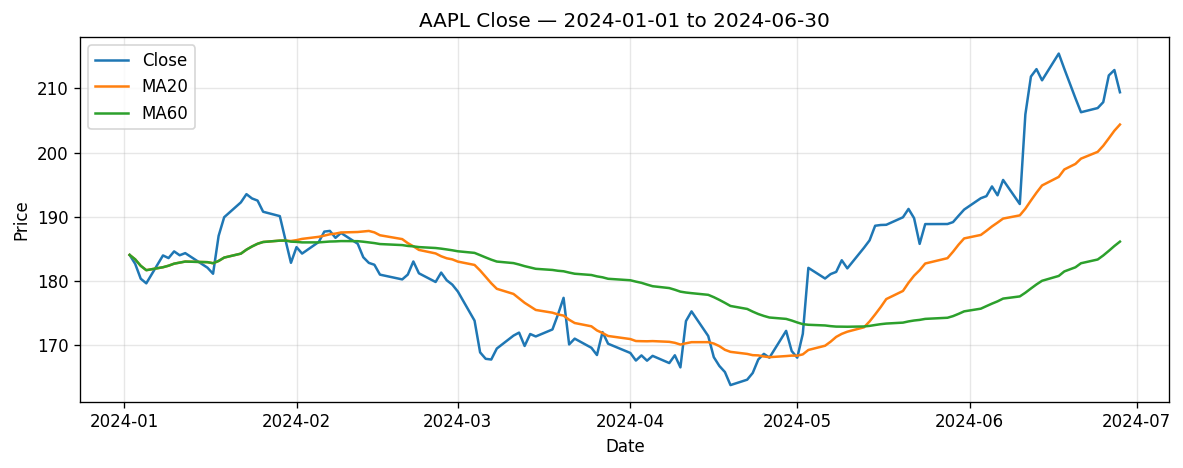

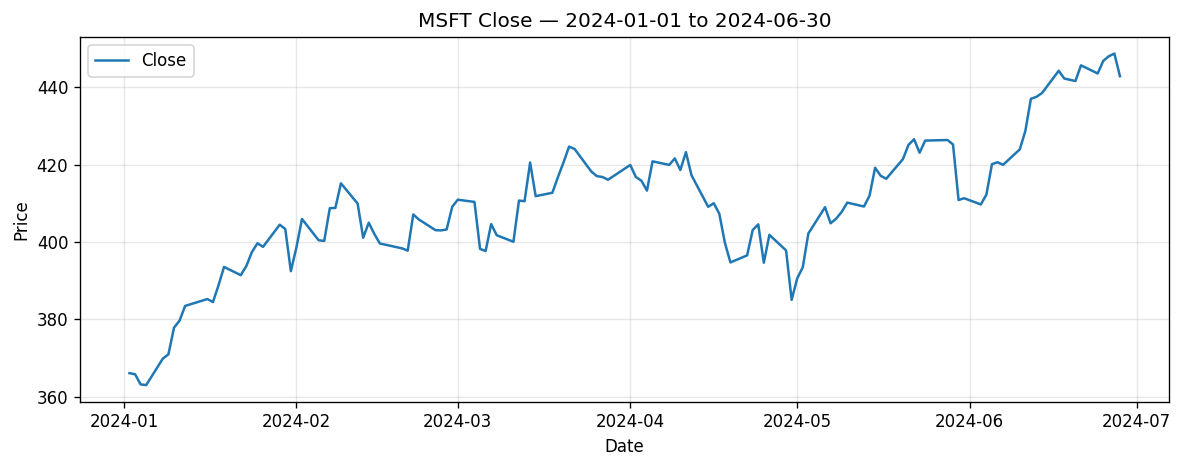

In [26]:
graph("AAPL")            # 기본: 종가 + MA20/MA60
graph("MSFT", ma=())     # 이동평균선 숨김


In [46]:
# === 일별 수익률 캐시 & 조회 유틸 ===
import numpy as np
import pandas as pd

# 티커별 일별 수익률 배열을 저장 (날짜 오름차순, 인덱스 0은 0.0)
_RETURNS_CACHE = {}  # key: 교정된 티커(e.g., BRK-B), value: np.ndarray(float)

def _norm_ticker(t: str) -> str:
    t = t.strip().upper()
    return _TICKER_FIX.get(t, t)  # BRK.B -> BRK-B 등 교정

def _compute_returns_from_df(df: pd.DataFrame) -> np.ndarray:
    prices = df["종가"].astype(float).to_numpy()
    ret = np.empty_like(prices, dtype=float)
    ret[0] = 0.0
    if len(prices) > 1:
        ret[1:] = prices[1:] / prices[:-1] - 1.0
    return ret

def build_returns_cache():
    """
    현재 _CACHE에 저장된 모든 티커에 대해 일별 수익률을 계산해 _RETURNS_CACHE에 저장.
    반환: 빌드된 티커 수와 티커 목록(교정 표기)
    """
    global _RETURNS_CACHE
    _RETURNS_CACHE = {}
    for t, df in _CACHE.items():
        if df is None or df.empty:
            continue
        _RETURNS_CACHE[t] = _compute_returns_from_df(df)
    return {"built": len(_RETURNS_CACHE), "tickers": sorted(_RETURNS_CACHE.keys())}

def profit_ratio(ticker: str):
    """
    해당 티커의 일별 수익률 리스트 반환 (날짜 순, 인덱스 0 = 0.0).
    _RETURNS_CACHE에 없으면 show()로 불러와 즉시 계산/저장 후 반환.
    """
    t = _norm_ticker(ticker)
    if t not in _RETURNS_CACHE:
        df = show(t)  # 필요 시 다운로드/캐시
        _RETURNS_CACHE[t] = _compute_returns_from_df(df)
    return _RETURNS_CACHE[t].tolist()

# 오타 방지용 별칭
def profir_ratio(ticker: str):
    return profit_ratio(ticker)

def returns_cached_tickers():
    """
    일별 수익률이 캐시된 티커 목록을 사람이 보기 좋은 표기로 반환 (예: BRK-B -> BRK.B).
    """
    inv = {v: k for k, v in _TICKER_FIX.items()}
    return sorted(inv.get(t, t) for t in _RETURNS_CACHE.keys())

# 사용 예:
# build_returns_cache()      # 현재 show()로 불러온 모든 티커에 대한 수익률 캐시 생성
# profit_ratio("AAPL")       # [0.0, 0.0123, -0.0045, ...]
# profir_ratio("AAPL")       # 동일 (오타 방지)
# returns_cached_tickers()   # 수익률 캐시가 만들어진 티커 목록


In [50]:
a=returns_cached_tickers()

In [51]:
len(a)

300

In [55]:
# === PATCH: returns_dict 안정화 (중첩 리스트/2D -> 1D float) ===
import numpy as np
import pandas as pd
import json

def _to_1d_float_list(arr) -> list[float]:
    """
    arr가 np.ndarray(1D/2D)든 list-of-lists든 상관없이
    1D float 리스트로 변환한다. 변환 실패 항목은 NaN으로 둠.
    """
    # 1) 빠른 경로: 바로 float 배열로 캐스팅
    try:
        a = np.asarray(arr, dtype=float)
        if a.ndim > 1:
            a = a.reshape(-1)
        return a.tolist()
    except Exception:
        pass
    # 2) 폴백: 개별 원소를 풀어서 float로 캐스팅
    flat = []
    for x in np.array(arr, dtype=object).ravel():
        try:
            # x가 [0.01]처럼 1길이 시퀀스인 경우
            if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 1:
                x = x[0]
            flat.append(float(x))
        except Exception:
            flat.append(float("nan"))
    return flat

def fix_returns_cache_shapes(inplace: bool = True):
    """
    _RETURNS_CACHE의 모든 값을 1D float ndarray로 정규화.
    """
    global _RETURNS_CACHE
    fixed = {}
    for t, arr in _RETURNS_CACHE.items():
        lst = _to_1d_float_list(arr)
        fixed[t] = np.asarray(lst, dtype=float)
    if inplace:
        _RETURNS_CACHE.clear()
        _RETURNS_CACHE.update(fixed)
        return {t: v.shape for t, v in _RETURNS_CACHE.items()}
    return fixed

def returns_dict(use_cache_only: bool = False,
                 pretty_keys: bool = True,
                 round_digits: int | None = None) -> dict:
    """
    키=티커, 값=일별 수익률 리스트 딕셔너리.
    """
    # 필요 시 _RETURNS_CACHE 채움
    if not use_cache_only:
        for t, df in list(_CACHE.items()):
            if df is None or df.empty:
                continue
            if t not in _RETURNS_CACHE:
                _RETURNS_CACHE[t] = _compute_returns_from_df(df)

    # 모양 정규화(중첩/2D -> 1D)
    fix_returns_cache_shapes(inplace=True)

    inv = {v: k for k, v in _TICKER_FIX.items()}  # BRK-B -> BRK.B
    out = {}
    for t, arr in _RETURNS_CACHE.items():
        key = inv.get(t, t) if pretty_keys else t
        lst = arr.tolist()
        if round_digits is not None:
            lst = [ (round(x, round_digits) if pd.notna(x) else float("nan")) for x in lst ]
        out[key] = lst
    return out

def save_returns_dict_json(path: str,
                           use_cache_only: bool = False,
                           pretty_keys: bool = True,
                           round_digits: int | None = None):
    d = returns_dict(use_cache_only=use_cache_only,
                     pretty_keys=pretty_keys,
                     round_digits=round_digits)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(d, f, ensure_ascii=False)
    return {"saved": path, "tickers": len(d)}


In [56]:
build_returns_cache()                               # 일별 수익률 채우기
shapes = fix_returns_cache_shapes()                 # 모양 정규화(선택)
d = returns_dict(pretty_keys=True, round_digits=6)  # 딕셔너리 생성
list(d.keys())[:5], len(d["AAPL"]), d["AAPL"][:5]

save_returns_dict_json("returns_daily.json", round_digits=6)


{'saved': 'returns_daily.json', 'tickers': 300}

In [86]:
len

{'AAPL': [0.0,
  -0.007497,
  -0.012698,
  -0.003992,
  0.024157,
  -0.002228,
  0.005665,
  -0.00325,
  0.001793,
  -0.012313,
  -0.005162,
  0.03257,
  0.015504,
  0.012161,
  0.006658,
  -0.003462,
  -0.001711,
  -0.009037,
  -0.003564,
  -0.019251,
  -0.019361,
  0.013344,
  -0.005397,
  0.009821,
  0.008651,
  0.000586,
  -0.00575,
  0.00407,
  -0.00896,
  -0.011301,
  -0.00479,
  -0.001586,
  -0.008436,
  -0.004088,
  0.00416,
  0.011269,
  -0.010051,
  -0.00745,
  0.008117,
  -0.006618,
  -0.00372,
  -0.006018,
  -0.025395,
  -0.028415,
  -0.00592,
  -0.000655,
  0.010191,
  0.011858,
  0.00274,
  -0.012094,
  0.010947,
  -0.002212,
  0.00636,
  0.013567,
  0.014758,
  -0.040868,
  0.005289,
  -0.008302,
  -0.006662,
  0.021187,
  -0.010519,
  -0.008458,
  -0.00699,
  0.004772,
  -0.004868,
  0.004474,
  -0.006652,
  0.007235,
  -0.01116,
  0.043283,
  0.008631,
  -0.02185,
  -0.019188,
  -0.008147,
  -0.005695,
  -0.01224,
  0.005128,
  0.006377,
  0.012673,
  0.005184,
  -0.00

In [59]:
# === Correlation from returns dict d (monthly-averaged, last-month rule) ===
import numpy as np
import pandas as pd
from itertools import combinations

# 내부 캐시
_COR_MONTHLY = {}   # { norm_ticker: pd.Series(index='YYYY-MM', values=mean monthly return) }
_COR_PAIR    = {}   # { (norm_a, norm_b): corr }
CORR_DICT    = {}   # public 저장: key="['A','B']" 문자열, value=corr

def _norm_ticker(t: str) -> str:
    """BRK.B -> BRK-B 등 yfinance 표기로 교정"""
    t = t.strip().upper()
    try:
        return _TICKER_FIX.get(t, t)
    except NameError:
        return t

def _pretty_ticker(t: str) -> str:
    """내부표기(BRK-B) -> 보기표기(BRK.B)"""
    inv = {v: k for k, v in _TICKER_FIX.items()}
    t = t.strip().upper()
    return inv.get(t, t)

def _to_1d_float_list(arr) -> list[float]:
    """리스트/넘파이(1D/2D) 무엇이든 1D float 리스트로 평탄화"""
    try:
        a = np.asarray(arr, dtype=float)
        if a.ndim > 1:
            a = a.reshape(-1)
        return a.tolist()
    except Exception:
        flat = []
        for x in np.array(arr, dtype=object).ravel():
            try:
                if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 1:
                    x = x[0]
                flat.append(float(x))
            except Exception:
                flat.append(float("nan"))
        return flat

def _get_dates_for_ticker(t_norm: str) -> pd.DatetimeIndex:
    """show()에서 날짜를 가져와 DatetimeIndex 반환"""
    df = show(t_norm)  # 필요시 다운로드/캐시
    if "날짜" in df.columns:
        di = pd.to_datetime(df["날짜"], format="%Y.%m.%d", errors="coerce")
    elif "Date" in df.columns:
        di = pd.to_datetime(df["Date"], errors="coerce")
    else:
        raise ValueError(f"show('{t_norm}') output has no date column")
    di = pd.DatetimeIndex(di.dropna()).sort_values()
    return di

def _monthly_avg_from_d(d: dict, ticker: str, min_days_last_month: int = 15) -> pd.Series:
    """
    d[티커]=일별수익률 리스트를 사용해 월 평균 수익률 시리즈 생성.
    - 마지막 달: 거래일 수 <15 제외, >=15 포함
    - 첫 날 수익률은 기준이 없어 NaN 처리(월 평균에서 자동 제외)
    """
    t_norm = _norm_ticker(ticker)
    if t_norm in _COR_MONTHLY:
        return _COR_MONTHLY[t_norm]

    # d에서 수익률 리스트 찾기 (보기표기/내부표기 모두 시도)
    t_pretty = _pretty_ticker(t_norm)
    ret_list = None
    if t_pretty in d:
        ret_list = d[t_pretty]
    elif t_norm in d:
        ret_list = d[t_norm]
    else:
        # d에 없으면 show() 기반으로 재계산(최소한 동작 보장)
        df = show(t_norm)
        prices = pd.to_numeric(df["종가"] if "종가" in df.columns else df["Close"], errors="coerce")
        ret = prices.pct_change().to_numpy()
        ret_list = ret.tolist()

    ret = np.asarray(_to_1d_float_list(ret_list), dtype=float)

    # 기준 날짜
    dates = _get_dates_for_ticker(t_norm)
    N = min(len(ret), len(dates))
    if N == 0:
        s = pd.Series(dtype=float)
        _COR_MONTHLY[t_norm] = s
        return s
    ret = ret[:N].astype(float)
    dates = dates[:N]

    # 첫 날 NaN 처리 (월 평균에 포함되지 않도록)
    if len(ret) > 0:
        ret[0] = np.nan

    df = pd.DataFrame({"Date": dates, "ret": ret})
    df["ym"] = df["Date"].dt.to_period("M")
    # 마지막 달 규칙
    counts = df.groupby("ym")["ret"].count()  # NaN 제외한 거래일 수
    if not counts.empty:
        last_ym = counts.index.max()
        if counts.loc[last_ym] < min_days_last_month:
            df = df[df["ym"] != last_ym]

    if df.empty:
        s = pd.Series(dtype=float)
    else:
        s = df.groupby("ym")["ret"].mean()
        s.index = s.index.astype(str)  # 'YYYY-MM'
    _COR_MONTHLY[t_norm] = s
    return s

def _pair_key(a: str, b: str):
    """상관 캐시용 내부 키(정렬된 튜플, 내부표기)"""
    a = _norm_ticker(a); b = _norm_ticker(b)
    return tuple(sorted((a, b)))

def cor(a: str, b: str, d: dict = None, min_days_last_month: int = 15) -> float:
    """
    cor('AAPL','MSFT') -> 두 종목의 월 평균 수익률 상관계수(피어슨)
    - d: returns 딕셔너리(키=티커, 값=일별수익률 리스트). 미지정이면 전역 d 가정.
    - 결과는 CORR_DICT["[A,B]"] = corr 형태로 저장 (A,B는 보기표기, 정렬됨)
    """
    if d is None:
        try:
            d = globals()["d"]  # 사용자가 d 라는 이름으로 보관했다고 가정
        except KeyError:
            raise ValueError("returns dict d 를 인자로 넘기거나 전역 변수 d 로 정의해 주세요.")

    key = _pair_key(a, b)
    if key in _COR_PAIR:
        corr = _COR_PAIR[key]
    else:
        sa = _monthly_avg_from_d(d, key[0], min_days_last_month)
        sb = _monthly_avg_from_d(d, key[1], min_days_last_month)
        if sa.empty or sb.empty:
            corr = float("nan")
        else:
            df = pd.concat([sa.rename("A"), sb.rename("B")], axis=1).dropna()
            corr = float("nan") if len(df) < 2 else float(df["A"].corr(df["B"]))
        _COR_PAIR[key] = corr

    # 공개 딕셔너리 저장(요구사항대로 "[A,B]" 문자열 키)
    a_pretty, b_pretty = sorted([_pretty_ticker(key[0]), _pretty_ticker(key[1])])
    CORR_DICT[f"[{a_pretty},{b_pretty}]"] = corr
    return corr

def build_all_correlations_from_d(d: dict, min_days_last_month: int = 15):
    """
    d의 모든 티커 쌍에 대해 cor() 계산 및 CORR_DICT 채우기.
    반환: {'tickers':N, 'pairs':M, 'nan_pairs':K}
    """
    # d 키(보기표기) → 내부표기로 정규화 & 중복 제거
    norm_tickers = sorted({_norm_ticker(k) for k in d.keys()})
    # 월 평균 캐시 미리 생성
    for t in norm_tickers:
        _monthly_avg_from_d(d, t, min_days_last_month=min_days_last_month)

    nan_cnt = 0
    for a, b in combinations(norm_tickers, 2):
        c = cor(a, b, d=d, min_days_last_month=min_days_last_month)
        if not np.isfinite(c):
            nan_cnt += 1
    return {"tickers": len(norm_tickers), "pairs": len(norm_tickers)*(len(norm_tickers)-1)//2, "nan_pairs": nan_cnt}

def get_corr_dict():
    """저장된 상관계수 사전(CORR_DICT) 반환"""
    return CORR_DICT


In [60]:
# d 는 returns_dict(...) 로 만든 딕셔너리라고 가정
# d = returns_dict(pretty_keys=True, round_digits=6)

cor("AAPL", "MSFT", d)         # 두 종목 상관계수 계산 & 저장
cor("BRK.B", "AAPL", d)        # 점(.) 표기 그대로 입력해도 OK

build_all_correlations_from_d(d)  # d의 모든 티커 쌍 상관계수 저장
cdict = get_corr_dict()
list(cdict.items())[:5]        # 예시로 앞 5개 확인


[('[AAPL,MSFT]', 0.45708708338542076),
 ('[AAPL,BRK.B]', -0.17276570509700517),
 ('[A,AAPL]', -0.4162594995611887),
 ('[A,ABBV]', 0.5504728748629975),
 ('[A,ABNB]', 0.5179051197201465)]

In [64]:
len(cdict)

44850

In [82]:
# === PATCH: label(노드 이름) 파란색 ===
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def draw_corr_network(
    G: nx.Graph,
    abs_threshold: float = 0.3,
    with_labels: bool = True,
    figsize=(18, 12),
    node_size: int = 40,
    label_fontsize: int = 8,
    label_color: str = "blue",   # ← 추가: 라벨 색
    edge_alpha: float = 0.6,
    edge_min: float = 0.15,
    edge_max: float = 1.5,
    k_layout: float | None = None,
    seed: int = 42
):
    # 임계치 필터
    edges_keep = [
        (u, v, d) for u, v, d in G.edges(data=True)
        if (d.get("abs_weight") is not None) and (d["abs_weight"] >= abs_threshold)
    ]
    H = nx.Graph()
    H.add_nodes_from(G.nodes(data=True))
    H.add_edges_from((u, v, d) for u, v, d in edges_keep)

    if H.number_of_edges() == 0:
        print(f"No edges with |corr| >= {abs_threshold}")
        return H

    pos = nx.spring_layout(H, seed=seed, k=k_layout)

    absw = np.array([H[u][v]["abs_weight"] for u, v in H.edges()])
    if len(absw) > 0:
        a, b = absw.min(), absw.max()
        widths = (edge_min + (absw - a) * (edge_max - edge_min) / (b - a)) if (np.isfinite(a) and np.isfinite(b) and b > a) else np.full_like(absw, (edge_min + edge_max)/2.0)
    else:
        widths = []

    edge_colors = ["#777777" if H[u][v].get("sign") == "pos" else "#000000" for u, v in H.edges()]

    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color="#222222", ax=ax)
    nx.draw_networkx_edges(H, pos, width=widths, edge_color=edge_colors, alpha=edge_alpha, ax=ax)
    if with_labels:
        nx.draw_networkx_labels(H, pos, font_size=label_fontsize, font_color=label_color, ax=ax)  # ← 파란색 라벨

    ax.set_title(f"Correlation network (|corr| ≥ {abs_threshold})", fontsize=12)
    ax.set_axis_off()
    plt.tight_layout()
    return H



In [83]:
# === weight ≥ 0.7 엣지만 남기는 서브그래프 ===
import networkx as nx

def subgraph_by_weight(G: nx.Graph, min_weight: float = 0.7, drop_isolates: bool = True) -> nx.Graph:
    """
    상관계수 weight가 min_weight 이상인 엣지만 유지.
    - drop_isolates=True면 고립 노드 제거.
    """
    H = nx.Graph()
    H.add_nodes_from(G.nodes(data=True))
    for u, v, d in G.edges(data=True):
        w = d.get("weight")
        if w is not None and float(w) >= float(min_weight):
            H.add_edge(u, v, **d)
    if drop_isolates:
        H.remove_nodes_from(list(nx.isolates(H)))
    return H


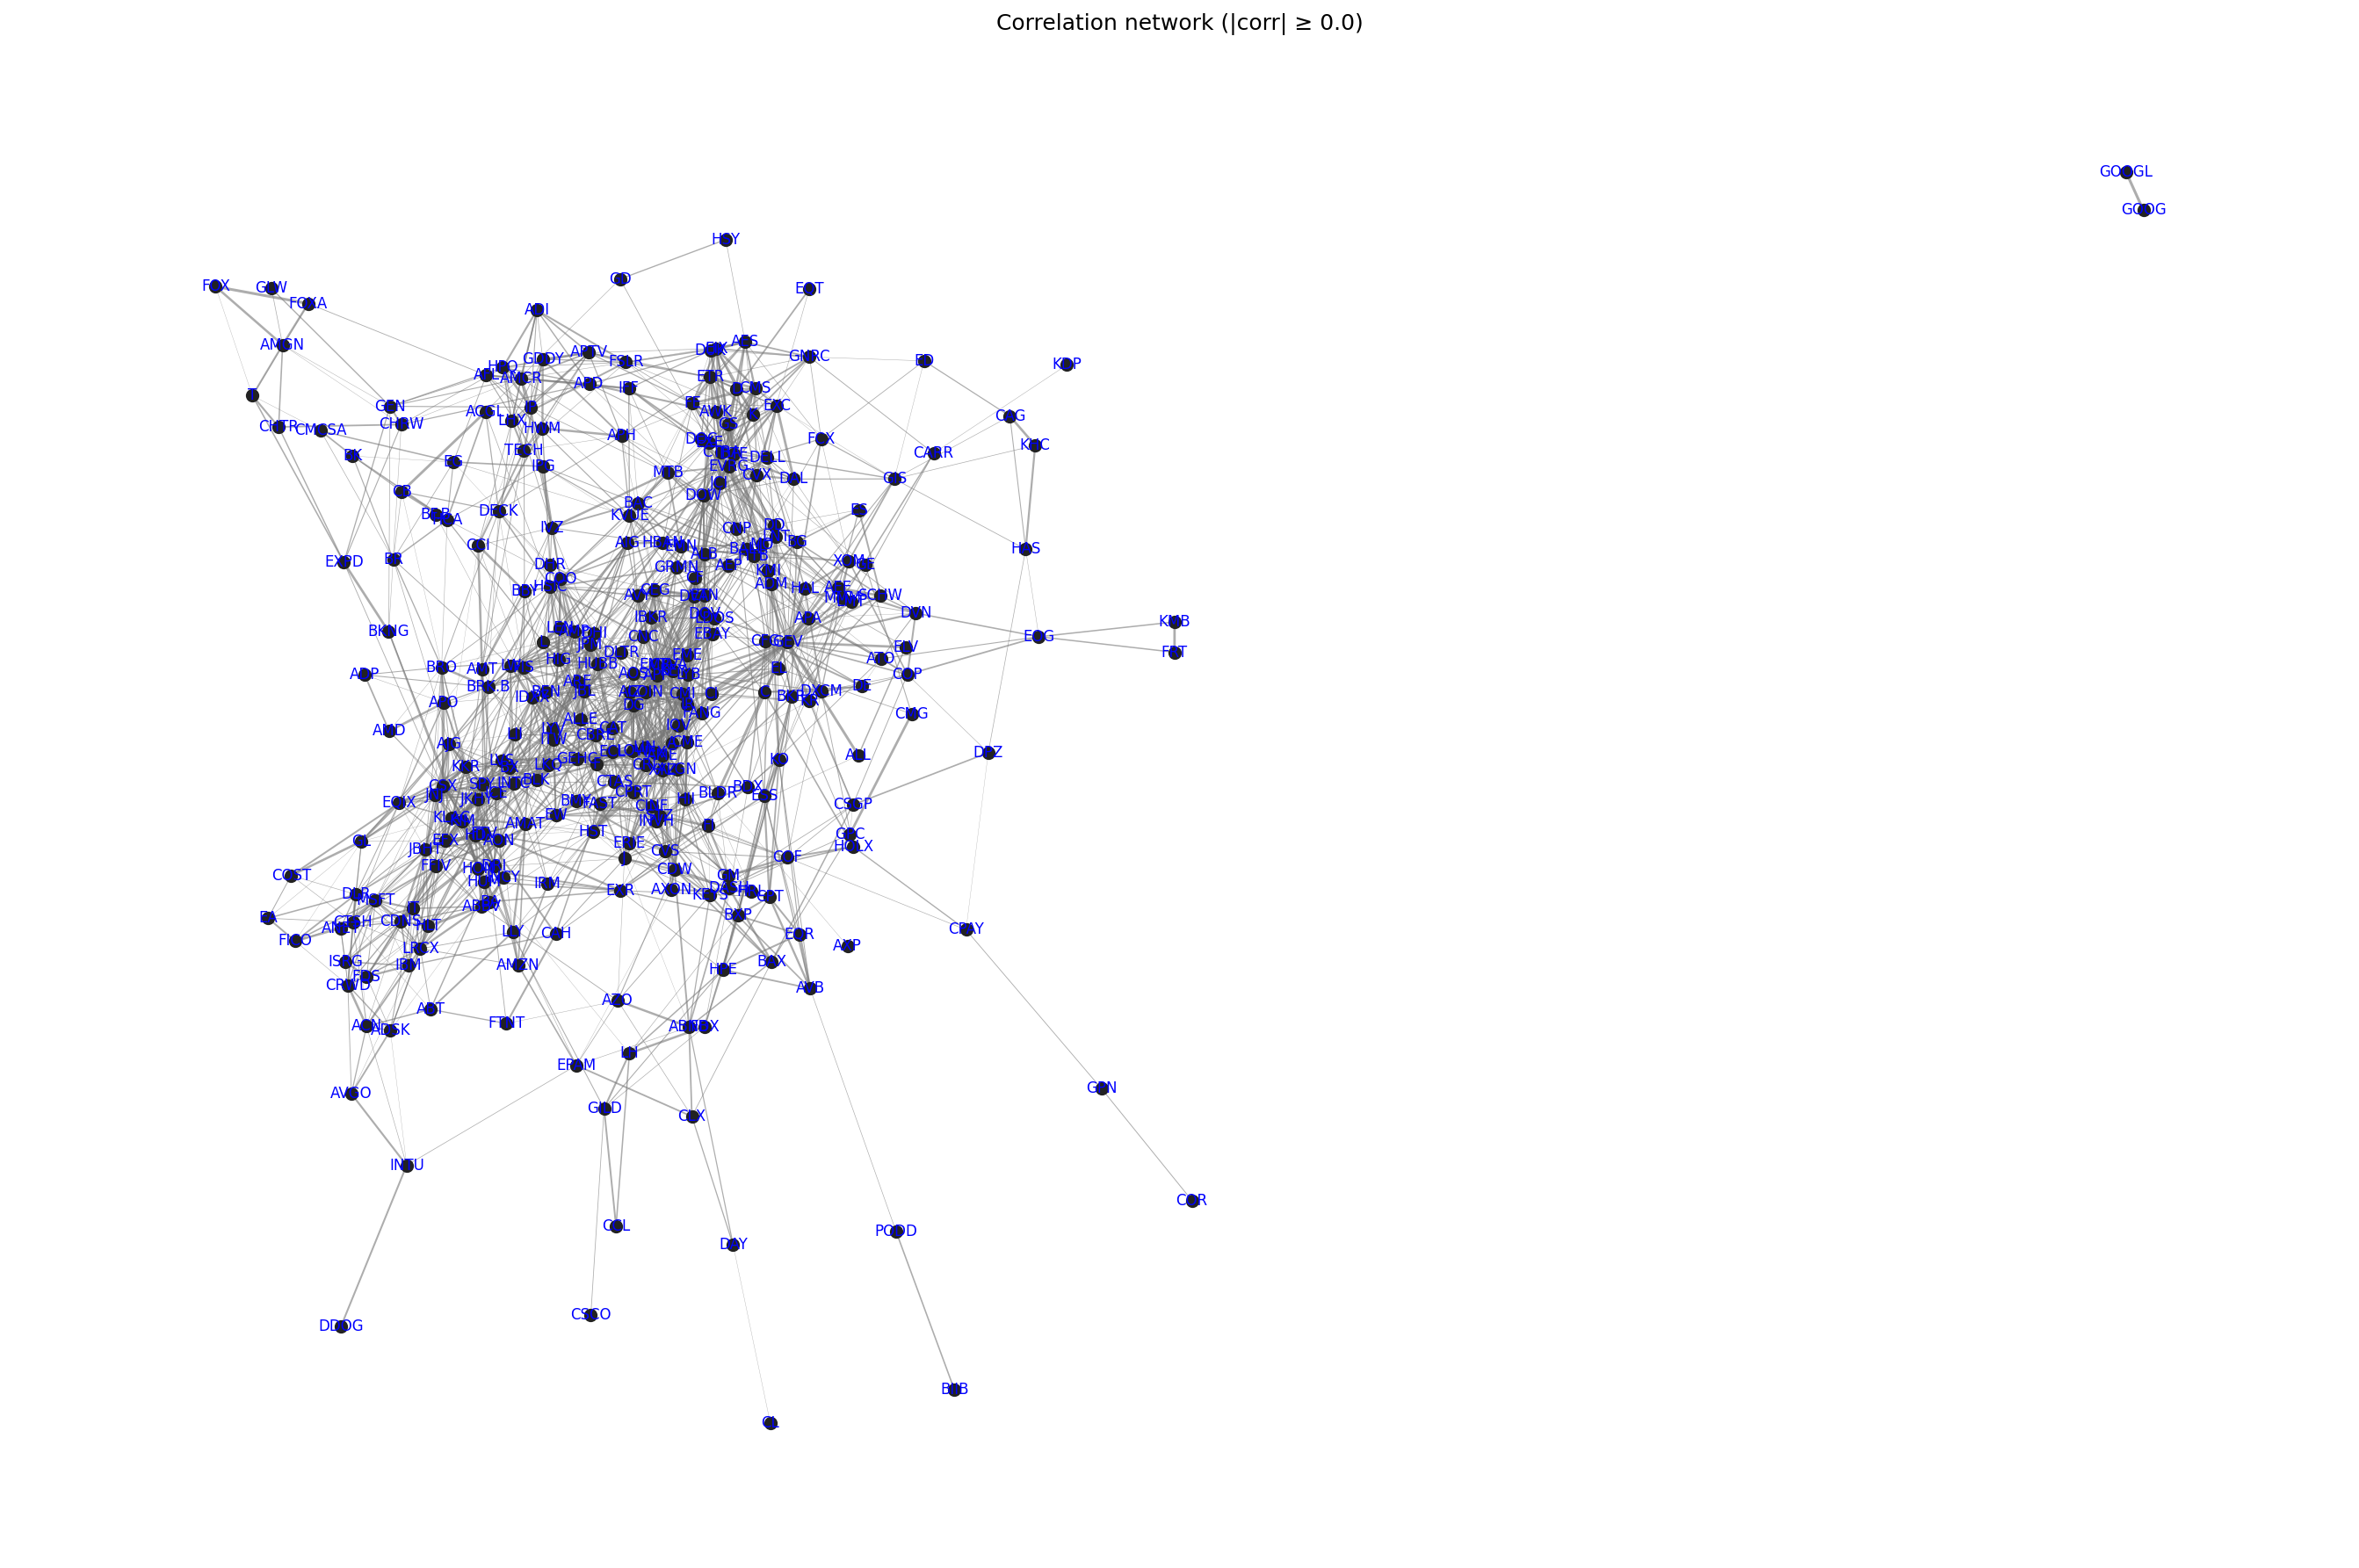

In [89]:
# 1) 원본 그래프 만들기
G = build_corr_graph_from_cdict(cdict)

# 2) weight ≥ 0.7만 남기기
H = subgraph_by_weight(G, min_weight=0.85)

# 3) 그리기 (추가 필터 없이 전부 표시하려면 abs_threshold=0)
draw_corr_network(H, abs_threshold=0.0, node_size=40, edge_max=1.5)
